In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [5]:
INIT_LR=1e-4
EPOCHS=20
BS=32

DIRECTORY=r'dataset'
CATEGORIES=['with_mask','without_mask']

data=[]
labels=[]

In [10]:
for category in CATEGORIES:
    path=os.path.join(DIRECTORY,category)
    for img in os.listdir(path):
        img_path=os.path.join(path,img)
        image=load_img(img_path,target_size=(224,224))
        image=img_to_array(image)
        image=preprocess_input(image)
        
        data.append(image)
        labels.append(category)

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [12]:
lb=LabelBinarizer()
labels=lb.fit_transform(labels)
labels=to_categorical(labels)

data=np.array(data,dtype='float32')
labels=np.array(labels)

trainX,testX,trainY,testY=train_test_split(data,labels,test_size=0.20,stratify=labels,random_state=42)

In [13]:
aug=ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,fill_mode='nearest')

In [14]:
baseModel=MobileNetV2(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))

In [15]:
headModel=baseModel.output
headModel=AveragePooling2D(pool_size=(7,7))(headModel)
headModel=Flatten(name='flatten')(headModel)
headModel=Dense(128,activation='relu')(headModel)
headModel=Dropout(0.5)(headModel)
headModel=Dense(2,activation='softmax')(headModel)

model=Model(inputs=baseModel.input,outputs=headModel)

In [16]:
for layer in baseModel.layers:
    layer.trainable=False

In [17]:
print('[INFO] compiling model...')

opt=Adam(lr=INIT_LR,decay=INIT_LR/EPOCHS)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])


[INFO] compiling model...


C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [18]:
print('[INFO] training head....')

H=model.fit(aug.flow(trainX,trainY,batch_size=BS),steps_per_epoch=len(trainX)//BS,validation_data=(testX,testY),validation_steps=len(testX)//BS,epochs=EPOCHS)

[INFO] training head....
Epoch 1/20
95/95 [==============================] - 96s 990ms/step - loss: 0.3812 - accuracy: 0.8657 - val_loss: 0.1570 - val_accuracy: 0.9701
Epoch 2/20
95/95 [==============================] - 92s 965ms/step - loss: 0.1433 - accuracy: 0.9648 - val_loss: 0.0764 - val_accuracy: 0.9818
Epoch 3/20
95/95 [==============================] - 89s 938ms/step - loss: 0.0969 - accuracy: 0.9733 - val_loss: 0.0566 - val_accuracy: 0.9844
Epoch 4/20
95/95 [==============================] - 85s 899ms/step - loss: 0.0734 - accuracy: 0.9806 - val_loss: 0.0494 - val_accuracy: 0.9844
Epoch 5/20
95/95 [==============================] - 89s 935ms/step - loss: 0.0629 - accuracy: 0.9816 - val_loss: 0.0452 - val_accuracy: 0.9857
Epoch 6/20
95/95 [==============================] - 97s 1s/step - loss: 0.0557 - accuracy: 0.9865 - val_loss: 0.0386 - val_accuracy: 0.9870
Epoch 7/20
95/95 [==============================] - 96s 1s/step - loss: 0.0561 - accuracy: 0.9822 - val_loss: 0.0375 - v

In [35]:
print('[INFO] evaluating network....')

predIdxs=model.predict(testX,batch_size=BS)

predIdxs=np.argmax(predIdxs,axis=1)

print(classification_report(testY.argmax(axis=1),predIdxs,target_names=lb.classes_))

[INFO] evaluating network....
              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       384
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       768
   macro avg       0.99      0.99      0.99       768
weighted avg       0.99      0.99      0.99       768



In [36]:
print('[INFO] saving mask detector model....')

model.save('data/mask_detector.model',save_format='h5')

[INFO] saving mask detector model....


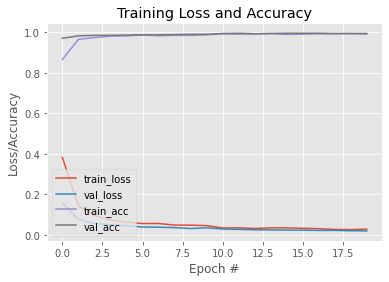

In [37]:
N=EPOCHS
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0,N),H.history['loss'],label='train_loss')
plt.plot(np.arange(0,N),H.history['val_loss'],label='val_loss')
plt.plot(np.arange(0,N),H.history['accuracy'],label='train_acc')
plt.plot(np.arange(0,N),H.history['val_accuracy'],label='val_acc')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='lower left')
plt.savefig('plot.png')

In [45]:
N=EPOCHS
plt.style.use('ggplot')
plt.figure()



<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

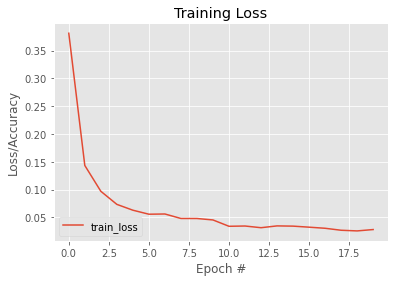

In [46]:
plt.plot(np.arange(0,N),H.history['loss'],label='train_loss')
plt.title('Training Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='lower left')
plt.savefig('graph/train_loss.png')

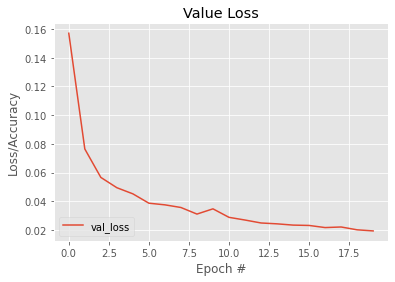

In [47]:
plt.plot(np.arange(0,N),H.history['val_loss'],label='val_loss')
plt.title('Value Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='lower left')
plt.savefig('graph/val_loss.png')

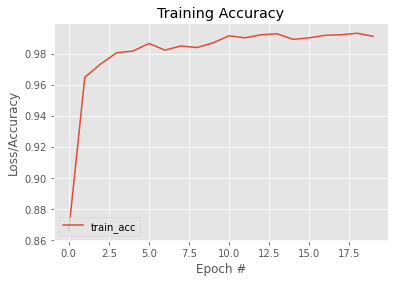

In [48]:
plt.plot(np.arange(0,N),H.history['accuracy'],label='train_acc')
plt.title('Training Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='lower left')
plt.savefig('graph/train_acc.png')

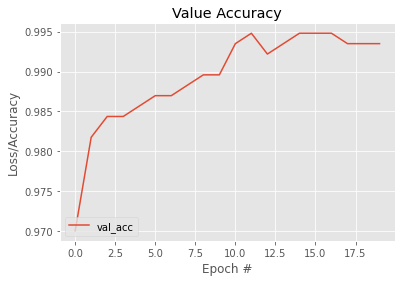

In [49]:
plt.plot(np.arange(0,N),H.history['val_accuracy'],label='val_acc')
plt.title('Value Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='lower left')
plt.savefig('graph/val_acc.png')